In [2]:
import anndata as ad
import pandas as pd
import numpy as np
import scanpy as sc
from statsmodels.stats.multitest import multipletests
from statsmodels.tools.tools import add_constant
import seaborn as sns
import matplotlib.pyplot as plt

from pypropeller import pypropeller
from pypropeller.utils import *
from pypropeller.linear_model import *
from pypropeller.get_transformed_props import *
from pypropeller.ebayes import *

# EXT205 scRNA Data

In [3]:
path = "/mnt/agnerds/yousef_alayoubi/ext205-cellxgene.h5ad"

In [4]:
def sim_reps(counts, props, n_reps, a, b, grp, n_sim=50, merge=True, cofactor=None, replicated=True, n=None, mu=None):
    """Simulate replicates by estimating distribution parameters from data.

    :param _type_ counts: _description_
    :param _type_ props: _description_
    :param _type_ n_reps: _description_
    :param _type_ a: _description_
    :param _type_ b: _description_
    :param _type_ grp: _description_
    :param int n_sim: _description_, defaults to 50
    :param bool merge: _description_, defaults to True
    :param _type_ cofactor: _description_, defaults to None
    :return _type_: _description_
    """
    res = {f'sim_{i+1}': {} for i in range(n_sim)}
    matrices = {f'sim_{i+1}': {} for i in range(n_sim)}
    for i in range(n_sim):
        n_reps_sim = n_reps
        counts_sim = simulate_cell_counts(counts, props, n_reps, a, b, n, mu)
        if merge:
            counts_sim = pd.merge(counts.T.reset_index(), counts_sim.reset_index(), 'outer').set_index('sample')
            n_reps_sim += 1
        props_sim, prop_trans_sim = get_tranformed_props_counts(counts_sim, replicated=replicated)
        props_sim = props_sim.sort_index()
        prop_trans_sim = prop_trans_sim.sort_index()
        
        # save matrices in dict
        matrices[f'sim_{i+1}']['counts'] = counts_sim
        matrices[f'sim_{i+1}']['props'] = props_sim

        conds = np.repeat(pd.unique(grp), n_reps_sim)  # reps = number of replicates + 1
        
        design = create_design(samples=props_sim.index, conds=conds, cofactors=cofactor, reindex=props_sim.index)
        matrices[f'sim_{i+1}']['design'] = design
        coef = np.arange(len(design.columns))
        out = pypropeller.t_test(props_sim, prop_trans_sim, design, [1,-1], robust=True)
        for k, cluster in enumerate(out.index):
            res[f'sim_{i+1}'][cluster] = out.iloc[k,-1]
    for i in range(n_sim):
        res[f'sim_{i+1}']['pass'] = res[f'sim_{i+1}']['1'] > 0.05 and res[f'sim_{i+1}']['2'] > 0.05 and res[f'sim_{i+1}']['3'] > 0.05 and res[f'sim_{i+1}']['4'] > 0.05 and res[f'sim_{i+1}']['5'] > 0.05
    
    res = pd.DataFrame(res).T
    
    return res, matrices

In [5]:
adata = sc.read_h5ad(path)
adata

/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/anndata/compat/__init__.py:232: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/anndata/compat/__init__.py:232: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


AnnData object with n_obs × n_vars = 1821 × 13910
    obs: 'Type', 'Chip', 'Detected genes', 'Total counts', 'Clustering (fine)'
    var: 'ensembl_gene_id', 'external_gene_name', 'gene_biotype', 'description', 'is_mito', 'n_cells_by_counts', 'log1p_mean_counts', 'mean_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Chip_colors', 'Type_colors', 'dendrogram_leiden_coarse', 'leiden', 'leiden_coarse_colors', 'neighbors', 'pca', 'phase_colors', 'rank_genes_groups', 'scRNAseq.preprocessing', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'tpm'
    obsp: 'distances', 'connectivities'

In [6]:
adata.obs

,Type,Chip,Detected genes,Total counts,Clustering (fine)
0,Cryo,105879,1527,9.114710,3
1,Sham,105879,5577,12.171336,4
3,Sham,105879,4273,11.614272,2
4,Sham,105879,2616,9.418899,1
5,Sham,105879,2038,8.791790,2
...,...,...,...,...,...
2500,Sham,105911,2161,9.025936,2
2501,Cryo,105911,4356,11.896254,3
2502,Cryo,105911,4954,11.653870,5
2503,Cryo,105911,2638,9.538421,2


In [7]:
# copying adata
adata_merged = adata.copy()
adata_merged.obs['sample'] = adata_merged.obs['Type'].map({'Cryo': 'S1', 'Sham': 'S2'})
adata_merged.obs


,Type,Chip,Detected genes,Total counts,Clustering (fine),sample
0,Cryo,105879,1527,9.114710,3,S1
1,Sham,105879,5577,12.171336,4,S2
3,Sham,105879,4273,11.614272,2,S2
4,Sham,105879,2616,9.418899,1,S2
5,Sham,105879,2038,8.791790,2,S2
...,...,...,...,...,...,...
2500,Sham,105911,2161,9.025936,2,S2
2501,Cryo,105911,4356,11.896254,3,S1
2502,Cryo,105911,4954,11.653870,5,S1
2503,Cryo,105911,2638,9.538421,2,S1


In [8]:
# adding sample column
adata.obs['sample'] = adata.obs['Type'].map({'Cryo': 'S1', 'Sham': 'S2'})
adata.obs['sample_2'] = adata.obs['Chip'].map({105879: '', 105911: '_rep'})
adata.obs['sample'] = adata.obs['sample'].astype(str) + adata.obs['sample_2'].astype(str)
adata.obs.drop('sample_2', axis=1, inplace=True)
adata.obs

,Type,Chip,Detected genes,Total counts,Clustering (fine),sample
0,Cryo,105879,1527,9.114710,3,S1
1,Sham,105879,5577,12.171336,4,S2
3,Sham,105879,4273,11.614272,2,S2
4,Sham,105879,2616,9.418899,1,S2
5,Sham,105879,2038,8.791790,2,S2
...,...,...,...,...,...,...
2500,Sham,105911,2161,9.025936,2,S2_rep
2501,Cryo,105911,4356,11.896254,3,S1_rep
2502,Cryo,105911,4954,11.653870,5,S1_rep
2503,Cryo,105911,2638,9.538421,2,S1_rep


In [9]:
out = pypropeller.pypropeller(adata, clusters='Clustering (fine)', sample='sample', cond='Type', transform='logit')
out

There are 2 conditions. T-Test will be performed...
Done!


,Baseline_props,Mean_props_Cryo,Mean_props_Sham,Prop_ratio,t_statistics,p_values,Adjusted_p_values
Clusters,,,,,,,
1,0.344316,0.355516,0.333006,1.067598,0.312643,0.760974,0.760974
2,0.232290,0.208661,0.259082,0.805385,-0.873461,0.402899,0.623590
3,0.169687,0.133776,0.207312,0.645288,-1.455015,0.176326,0.440814
4,0.134541,0.178707,0.083513,2.139862,2.832360,0.017780,0.088899
5,0.119165,0.123340,0.117086,1.053407,0.701699,0.498872,0.623590


In [10]:
pypropeller.pypropeller(adata, clusters='Clustering (fine)', sample='sample', cond='Type', transform='arcsin')

There are 2 conditions. T-Test will be performed...
Done!


,Baseline_props,Mean_props_Cryo,Mean_props_Sham,Prop_ratio,t_statistics,p_values,Adjusted_p_values
Clusters,,,,,,,
1,0.344316,0.355516,0.333006,1.067598,0.403252,0.695250,0.718586
2,0.232290,0.208661,0.259082,0.805385,-1.015491,0.333811,0.556352
3,0.169687,0.133776,0.207312,0.645288,-1.525514,0.158115,0.395287
4,0.134541,0.178707,0.083513,2.139862,2.446472,0.034465,0.172326
5,0.119165,0.123340,0.117086,1.053407,0.370710,0.718586,0.718586


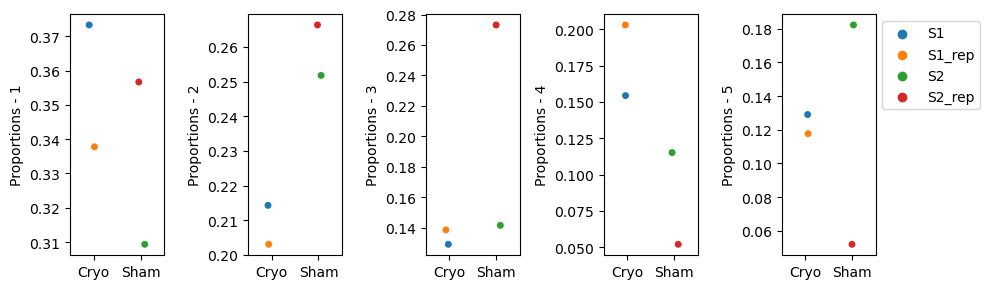

In [11]:
counts, props, prop_trans = get_transformed_props(adata, sample_col='sample', cluster_col='Clustering (fine)')


fig, axes = plt.subplots(nrows=1, ncols=len(out.index), figsize=(10, 3))
axes = axes.flatten()
x = np.repeat(pd.unique(adata.obs.Type.to_list()), len(pd.unique(adata.obs.Type.to_list())))
for i, cluster in enumerate(props.columns):
    legend = True if i == len(axes) -1 else False
    ax = sns.stripplot(data=props, y=cluster, x=x, hue='sample', legend=legend, jitter=True, ax=axes[i])
    ax.set(ylabel='Proportions - '+cluster)
    #ax.legend()
    #plt.axline(xy1=(0, fit_props['coefficients'][0][0]), slope=fit_props['coefficients'][1][0])

ax.legend()
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
fig.tight_layout()

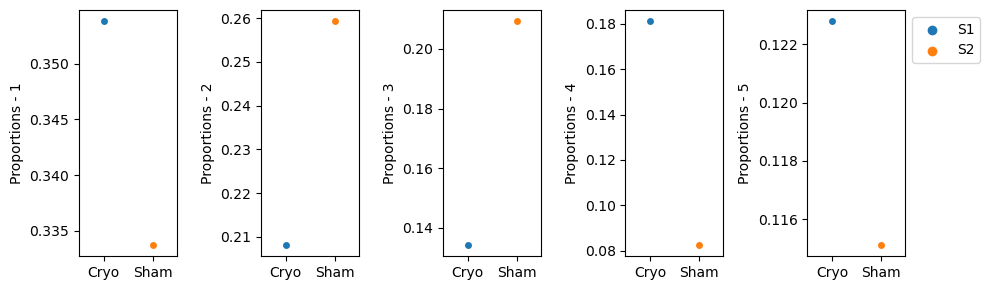

In [12]:
counts, props, prop_trans = get_transformed_props(adata_merged, sample_col='sample', cluster_col='Clustering (fine)')


fig, axes = plt.subplots(nrows=1, ncols=len(out.index), figsize=(10, 3))
axes = axes.flatten()
x = np.repeat(pd.unique(adata_merged.obs.Type.to_list()), 1)
for i, cluster in enumerate(props.columns):
    legend = True if i == len(axes) -1 else False
    ax = sns.stripplot(data=props, y=cluster, x=x, hue='sample', legend=legend, jitter=True, ax=axes[i])
    ax.set(ylabel='Proportions - '+cluster)
    #ax.legend()
    #plt.axline(xy1=(0, fit_props['coefficients'][0][0]), slope=fit_props['coefficients'][1][0])

ax.legend()
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
fig.tight_layout()

### Removing replicates

In [13]:
adata_norep = adata[(np.array(adata.obs.loc[:,'sample']=='S1') | np.array(adata.obs.loc[:,'sample']=='S2'))]
adata_norep

View of AnnData object with n_obs × n_vars = 851 × 13910
    obs: 'Type', 'Chip', 'Detected genes', 'Total counts', 'Clustering (fine)', 'sample'
    var: 'ensembl_gene_id', 'external_gene_name', 'gene_biotype', 'description', 'is_mito', 'n_cells_by_counts', 'log1p_mean_counts', 'mean_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Chip_colors', 'Type_colors', 'dendrogram_leiden_coarse', 'leiden', 'leiden_coarse_colors', 'neighbors', 'pca', 'phase_colors', 'rank_genes_groups', 'scRNAseq.preprocessing', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'tpm'
    obsp: 'distances', 'connectivities'

In [14]:
counts_norep, props_norep, prop_trans_norep = get_transformed_props(adata_norep, sample_col='sample', cluster_col='Clustering (fine)', transform='logit')
baseline_props_norep = adata_norep.obs['Clustering (fine)'].value_counts()/adata_norep.obs.shape[0]  # proportions of each cluster in all samples
props_norep

Clustering (fine),1,2,3,4,5
sample,,,,,
S1,0.373272,0.214286,0.129032,0.154378,0.129032
S2,0.309353,0.251799,0.141487,0.115108,0.182254


In [15]:
counts_merged, props_merged, prop_trans_merged = get_transformed_props(adata_merged, sample_col='sample', cluster_col='Clustering (fine)', transform='logit')
baseline_props_norep = adata_norep.obs['Clustering (fine)'].value_counts()/adata_merged.obs.shape[0]  # proportions of each cluster in all samples
props_merged

Clustering (fine),1,2,3,4,5
sample,,,,,
S1,0.353798,0.208117,0.134235,0.181061,0.122789
S2,0.333721,0.259302,0.209302,0.082558,0.115116


In [16]:
design_norep = create_design('sample', 'Type', data=adata_norep)
coef = np.arange(len(design_norep.columns))
design_norep

Group,Cryo,Sham
Sample,,
S1,1,0
S2,0,1


In [17]:
#pypropeller.anova(props_norep, prop_trans_norep, design_norep, coef, robust=True)

## Bootstrapping

In [18]:
def sim_boot_reps(adata, n_sims=20, n_boots=2, clusters='cluster', conds='group', samples='sample'):
    import warnings
    import anndata
    warnings.simplefilter(action='ignore', category=FutureWarning)
    warnings.simplefilter(action='ignore', category=anndata.ImplicitModificationWarning)
    warnings.simplefilter(action='ignore', category=UserWarning)

    # create dict for simulation results
    res = {f'sim_{i+1}': {} for i in range(n_sims)}
    adatas = {f'sim_{i+1}': {} for i in range(n_sims)}
    for i in range(n_sims):
        reps = boot_reps(adata, n_boots=n_boots, samples=samples)
        adata_rep = adata.concatenate(reps, join='outer')
        adata_rep.obs_names_make_unique()
        adatas[f'sim_{i+1}'] = adata_rep
        out = pypropeller.pypropeller(adata_rep, clusters=clusters, sample=samples, cond=conds, transform='logit')
        for k, cluster in enumerate(out.index):
            res[f'sim_{i+1}'][cluster] = out.iloc[k,-1]
    for i in range(n_sims):
        res[f'sim_{i+1}']['pass'] = res[f'sim_{i+1}']['1'] > 0.05 and res[f'sim_{i+1}']['2'] > 0.05 and res[f'sim_{i+1}']['3'] > 0.05 and res[f'sim_{i+1}']['4'] > 0.05 and res[f'sim_{i+1}']['5'] > 0.05

    res = pd.DataFrame(res).T
    
    return res, adatas, adata_rep

### adata with s1_rep and s2_rep removed

In [19]:
n_sims = 10
res, adatas, rep_adata = sim_boot_reps(adata_norep, n_sims=n_sims, n_boots=1, clusters='Clustering (fine)', conds='Type', samples='sample')

There are 2 conditions. T-Test will be performed...
Done!
There are 2 conditions. T-Test will be performed...
Done!
There are 2 conditions. T-Test will be performed...
Done!
There are 2 conditions. T-Test will be performed...
Done!
There are 2 conditions. T-Test will be performed...
Done!
There are 2 conditions. T-Test will be performed...
Done!
There are 2 conditions. T-Test will be performed...
Done!
There are 2 conditions. T-Test will be performed...
Done!
There are 2 conditions. T-Test will be performed...
Done!
There are 2 conditions. T-Test will be performed...
Done!


In [20]:
res

,1,2,3,4,5,pass
sim_1,0.40649,0.679826,0.679826,0.111523,0.007364,False
sim_2,0.006003,0.195911,0.04453,0.004255,0.004255,False
sim_3,0.026274,0.320408,0.157249,0.01209,0.001845,False
sim_4,0.01651,0.060886,0.027207,0.000583,0.000583,False
sim_5,0.014916,0.102413,0.102413,0.005868,0.002365,False
sim_6,0.000207,0.001402,0.008442,0.001188,0.000207,False
sim_7,0.001259,0.002895,0.102423,0.002895,0.001259,False
sim_8,0.000451,0.003867,0.004911,0.000451,0.000451,False
sim_9,0.036185,0.020297,0.367659,0.001184,0.002288,False
sim_10,0.194145,0.062921,0.961529,0.062921,0.205285,True


In [21]:
rep_adata.obs['Clustering (fine)'].value_counts()

1    546
2    423
5    265
4    238
3    230
Name: Clustering (fine), dtype: int64

In [29]:
# with two replicate
n_sims = 10
res, adatas, adata_rep = sim_boot_reps(adata_norep, n_sims=n_sims, n_boots=2, clusters='Clustering (fine)', conds='Type', samples='sample')

There are 2 conditions. T-Test will be performed...
Done!
There are 2 conditions. T-Test will be performed...
Done!
There are 2 conditions. T-Test will be performed...
Done!
There are 2 conditions. T-Test will be performed...
Done!
There are 2 conditions. T-Test will be performed...
Done!
There are 2 conditions. T-Test will be performed...
Done!
There are 2 conditions. T-Test will be performed...
Done!
There are 2 conditions. T-Test will be performed...
Done!
There are 2 conditions. T-Test will be performed...
Done!
There are 2 conditions. T-Test will be performed...
Done!


In [30]:
res

,1,2,3,4,5,pass
sim_1,0.00048,0.000068,0.746579,0.000009,0.000009,False
sim_2,0.000241,0.002471,0.015707,0.00036,0.000104,False
sim_3,0.014702,0.014702,0.494371,0.000504,0.000756,False
sim_4,0.000015,0.041231,0.000823,0.000015,0.0,False
sim_5,0.001135,0.017862,0.022012,0.000033,0.000015,False
sim_6,0.000464,0.000464,0.566694,0.000401,0.000198,False
sim_7,0.053544,0.082646,0.722889,0.053544,0.001473,False
sim_8,0.000938,0.039586,0.043834,0.000007,0.000004,False
sim_9,0.103632,0.454087,0.921639,0.103632,0.004151,False
sim_10,0.0,0.000001,0.00155,0.0,0.0,False


### adata with s1_rep and s2_rep merged with s1 and s2

In [22]:
props_merged

Clustering (fine),1,2,3,4,5
sample,,,,,
S1,0.353798,0.208117,0.134235,0.181061,0.122789
S2,0.333721,0.259302,0.209302,0.082558,0.115116


In [23]:
n_sims = 10
res, adatas, rep_adata_merged = sim_boot_reps(adata_merged, n_sims=n_sims, n_boots=1, clusters='Clustering (fine)', conds='Type', samples='sample')

There are 2 conditions. T-Test will be performed...
Done!
There are 2 conditions. T-Test will be performed...
Done!
There are 2 conditions. T-Test will be performed...
Done!
There are 2 conditions. T-Test will be performed...
Done!
There are 2 conditions. T-Test will be performed...
Done!
There are 2 conditions. T-Test will be performed...
Done!
There are 2 conditions. T-Test will be performed...
Done!
There are 2 conditions. T-Test will be performed...
Done!
There are 2 conditions. T-Test will be performed...
Done!
There are 2 conditions. T-Test will be performed...
Done!


In [24]:
res

,1,2,3,4,5,pass
sim_1,0.126225,0.000706,0.000002,0.0,0.162382,False
sim_2,0.183414,0.000041,0.0,0.0,0.006911,False
sim_3,0.992493,0.005026,0.000006,0.0,0.019474,False
sim_4,0.221406,0.006878,0.000669,0.000024,0.397392,False
sim_5,0.103599,0.000997,0.0,0.0,0.739932,False
sim_6,0.056016,0.000542,0.000003,0.0,0.891663,False
sim_7,0.046377,0.000888,0.000027,0.000002,0.046377,False
sim_8,0.464976,0.009793,0.000009,0.000001,0.029546,False
sim_9,0.091986,0.000236,0.000017,0.0,0.119438,False
sim_10,0.021202,0.000003,0.0,0.0,0.042282,False


In [25]:
rep_adata_merged.obs

,Type,Chip,Detected genes,Total counts,Clustering (fine),sample,batch
0-0,Cryo,105879,1527,9.114710,3,S1,0
1-0,Sham,105879,5577,12.171336,4,S2,0
3-0,Sham,105879,4273,11.614272,2,S2,0
4-0,Sham,105879,2616,9.418899,1,S2,0
5-0,Sham,105879,2038,8.791790,2,S2,0
...,...,...,...,...,...,...,...
2483-1-2,Sham,105911,3408,10.372959,4,S2_rep_1,2
1935-4-2,Sham,105911,2014,8.799812,1,S2_rep_1,2
677-1-2,Sham,105879,4165,11.183310,2,S2_rep_1,2
1114-2,Sham,105879,2322,9.675959,3,S2_rep_1,2


In [26]:
pd.crosstab(adatas['sim_1'].obs['Clustering (fine)'], adatas['sim_1'].obs['Type'])

Type,Cryo,Sham
Clustering (fine),,
1,691,582
2,383,422
3,260,367
4,345,146
5,243,203


In [27]:
pd.crosstab(adata.obs['Clustering (fine)'], adata.obs['Type'])

Type,Cryo,Sham
Clustering (fine),,
1,340,287
2,200,223
3,129,180
4,174,71
5,118,99


##### Example run

In [38]:
reps = boot_reps(adata_merged, n_boots=1, samples='sample')
adata_rep = adata_merged.concatenate(reps, join='outer')

In [39]:
test = pypropeller.pypropeller(adata_rep, clusters='Clustering (fine)', sample='sample', cond='Type', transform='arcsin')
test

There are 2 conditions. T-Test will be performed...
Done!


,Baseline_props,Mean_props_Cryo,Mean_props_Sham,Prop_ratio,t_statistics,p_values,Adjusted_p_values
Clusters,,,,,,,
1,0.331411,0.347555,0.313372,1.109080,1.920067,0.085126,0.106407
2,0.246842,0.224246,0.272093,0.824150,-2.875458,0.017240,0.028734
3,0.175728,0.137877,0.218023,0.632397,-6.279800,0.000111,0.000277
4,0.125206,0.167014,0.078488,2.127876,7.436576,0.000028,0.000142
5,0.120813,0.123309,0.118023,1.044786,0.507989,0.622968,0.622968


In [40]:
out

,Baseline_props,Mean_props_Cryo,Mean_props_Sham,Prop_ratio,t_statistics,p_values,Adjusted_p_values
Clusters,,,,,,,
1,0.344316,0.355516,0.333006,1.067598,0.312643,0.760974,0.760974
2,0.232290,0.208661,0.259082,0.805385,-0.873461,0.402899,0.623590
3,0.169687,0.133776,0.207312,0.645288,-1.455015,0.176326,0.440814
4,0.134541,0.178707,0.083513,2.139862,2.832360,0.017780,0.088899
5,0.119165,0.123340,0.117086,1.053407,0.701699,0.498872,0.623590


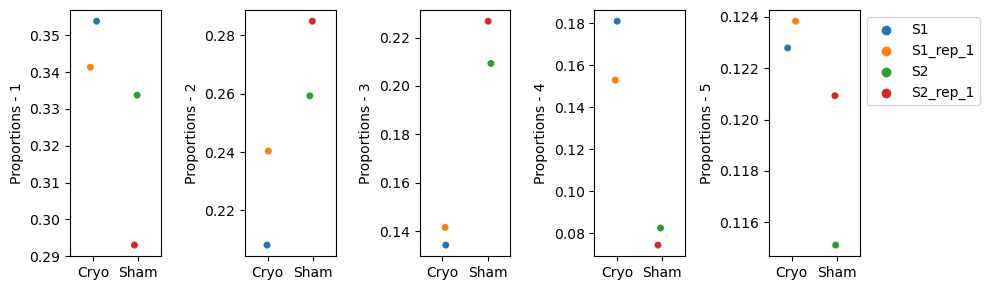

In [42]:
counts, props, prop_trans = get_transformed_props(adata_rep, sample_col='sample', cluster_col='Clustering (fine)')


fig, axes = plt.subplots(nrows=1, ncols=len(test.index), figsize=(10, 3))
axes = axes.flatten()
x = np.repeat(pd.unique(adata_rep.obs.Type.to_list()), 2)
for i, cluster in enumerate(props.columns):
    legend = True if i == len(axes) -1 else False
    ax = sns.stripplot(data=props, y=cluster, x=x, hue='sample', legend=legend, jitter=True, ax=axes[i])
    ax.set(ylabel='Proportions - '+cluster)

ax.legend()
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
fig.tight_layout()

In [1]:
# with 5 replicates
#n_sims = 10
#res, adatas = sim_boot_reps(adata_merged, n_sims=n_sims, n_boots=5, clusters='Clustering (fine)', conds='Type', samples='sample')

In [17]:
res

,1,2,3,4,5,pass
sim_1,0.278187,0.000273,0.0,0.0,0.250874,False
sim_2,0.008122,0.000035,0.0,0.0,0.259854,False
sim_3,0.005177,0.0,0.0,0.0,0.443275,False
sim_4,0.048262,0.00029,0.0,0.0,0.148561,False
sim_5,0.001031,0.0,0.0,0.0,0.343472,False
sim_6,0.100528,0.000021,0.0,0.0,0.316507,False
sim_7,0.019063,0.0,0.0,0.0,0.303174,False
sim_8,0.042315,0.0,0.0,0.0,0.019286,False
sim_9,0.025179,0.0,0.0,0.0,0.420528,False
sim_10,0.000802,0.0,0.0,0.0,0.004871,False


## Simulation from distribution

### s1_rep and s2_rep removed

In [28]:
props_norep.T

sample,S1,S2
Clustering (fine),,
1,0.373272,0.309353
2,0.214286,0.251799
3,0.129032,0.141487
4,0.154378,0.115108
5,0.129032,0.182254


In [29]:
# get true props for each cluster in each sample
groups_props = []
for group in props_norep.T.columns:
    groups_props.append(np.array(props_norep.T[group].to_list()))
grp1_trueprops = groups_props[0]
grp2_trueprops = groups_props[1]

grp1_trueprops

array([0.37327189, 0.21428571, 0.12903226, 0.15437788, 0.12903226])

In [30]:
# estimate beta paramters from proportions
a_prop, b_prob = estimate_beta_params(props_norep.T)  # rows are clusters, cols are samples

a_prop, b_prob

(Clustering (fine)
 1     37.220649
 2     58.965411
 3    203.848363
 4     20.238768
 5     14.286614
 dtype: float64,
 Clustering (fine)
 1      71.830971
 2     194.059265
 3    1303.242162
 4     129.964086
 5      77.504169
 dtype: float64)

In [31]:
counts_norep_t = counts_norep.T

# total sum per row and column
counts_norep_t.loc['sum',:]= counts_norep_t.sum(axis=0)
#Total sum per row: 
counts_norep_t.loc[:,'sum'] = counts_norep_t.sum(axis=1)
# proportion of each cluster in all samples
true_props = counts_norep_t.iloc[:,-1].div(counts_norep_t["sum"][-1], axis=0)  # sum of cells in cluster / sum of all cells
true_props = true_props.iloc[:-1].to_frame(name="props")
true_props

,props
Clustering (fine),
1,0.341951
2,0.232667
3,0.135135
4,0.135135
5,0.155112


In [32]:
counts_norep_t

sample,S1,S2,sum
Clustering (fine),,,
1,162.0,129.0,291.0
2,93.0,105.0,198.0
3,56.0,59.0,115.0
4,67.0,48.0,115.0
5,56.0,76.0,132.0
sum,434.0,417.0,851.0


In [33]:
# get props for each cluster in all samples
true_props_2 = counts_norep_t.iloc[:,:-1].div(counts_norep_t["sum"][-1], axis=0)
true_props_2 = true_props_2.iloc[:-1,:]
true_props_2

sample,S1,S2
Clustering (fine),,
1,0.190364,0.151586
2,0.109283,0.123384
3,0.065805,0.069330
4,0.078731,0.056404
5,0.065805,0.089307


In [34]:
# new method; estimate beta paramters from proportions of each cluster in all samples
a_prop_2, b_prob_2 = estimate_beta_params(true_props_2)  # rows are clusters

a_prop_2, b_prob_2

(Clustering (fine)
 1     32.061641
 2    120.172738
 3    685.011261
 4     17.011960
 5     20.013278
 dtype: float64,
 Clustering (fine)
 1     155.460397
 2     912.827262
 3    9453.155405
 4     234.765048
 5     238.036722
 dtype: float64)

In [35]:
counts_norep_t = counts_norep_t.iloc[:-1,:-1]
counts_norep_t

sample,S1,S2
Clustering (fine),,
1,162.0,129.0
2,93.0,105.0
3,56.0,59.0
4,67.0,48.0
5,56.0,76.0


In [36]:
# old method; calculate beta params from proportions of each cluster in each sample -> n_cells in cluster/n_cells in sample
b1_prop = a_prop*(1-grp1_trueprops)/grp1_trueprops
b2_prop = a_prop*(1-grp2_trueprops)/grp2_trueprops

b_prop_grps = [b1_prop.values,b2_prop.values]
b_prop_grps

[array([  62.49392859,  216.20650869, 1375.97644741,  110.8601151 ,
          96.43464166]),
 array([  83.09726209,  175.21150834, 1236.91040345,  155.58552598,
          64.10177935])]

In [37]:
# new method; calculate beta params from proportions of each cluster in all samples -> n_cells in cluster/n_cells in dataset
grp1_trueprops_2 = true_props_2.iloc[:,0].values
grp2_trueprops_2 = true_props_2.iloc[:,1].values

# using first estimation of alpha
b1_prop_2 = a_prop*(1-grp1_trueprops_2)/grp1_trueprops_2
b2_prop_2 = a_prop*(1-grp2_trueprops_2)/grp2_trueprops_2

b_prop_grps_2 = [b1_prop_2.values,b2_prop_2.values]
b_prop_grps_2

[array([ 158.30263528,  480.59980524, 2893.91871876,  236.82378812,
         202.81888921]),
 array([ 208.32021954,  418.93520904, 2736.40513835,  338.57771643,
         145.68586216])]

In [38]:
# new method
# using second estimation of alpha
b1_prop_22 = a_prop_2*(1-grp1_trueprops_2)/grp1_trueprops_2
b2_prop_22 = a_prop_2*(1-grp2_trueprops_2)/grp2_trueprops_2

b_prop_grps_22 = [b1_prop_22.values,b2_prop_22.values]
b_prop_grps_22

[array([ 136.36093053,  979.47242333, 9724.71344112,  199.06532323,
         284.11707865]),
 array([ 179.44577445,  853.79869062, 9195.40540541,  284.59591452,
         204.08277414])]

In [39]:
n_reps = 1
conds_reps = np.repeat(adata_norep.obs.Type.unique().to_list(), n_reps)
conds_reps

array(['Cryo', 'Sham'], dtype='<U4')

#### 20 Simulations with 1 replicate each -> 2 samples

In [40]:
# fitting done on sum of cells in each sample
n_reps = 1
res, data = sim_reps(counts_norep_t, true_props, n_reps, a_prop, b_prop_grps, conds_reps, n_sim=20, merge=True, cofactor=None, replicated=True)

/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract

In [41]:
res

,1,2,3,4,5,pass
sim_1,0.367099,0.215347,0.302085,0.024612,0.367099,False
sim_2,0.145549,0.697564,0.359395,0.19669,0.063627,True
sim_3,0.083655,0.899063,0.083655,0.018319,0.025984,False
sim_4,0.177732,0.046992,0.627684,0.046992,0.405974,False
sim_5,0.010017,0.037022,0.467408,0.037022,0.031083,False
sim_6,0.819777,0.819777,0.819777,0.021739,0.021739,False
sim_7,0.039958,0.490006,0.490006,0.156981,0.039958,False
sim_8,0.05324,0.312399,0.709268,0.00374,0.00029,False
sim_9,0.112633,0.032236,0.760804,0.001657,0.006455,False
sim_10,0.023488,0.070876,0.035647,0.012526,0.000141,False


In [42]:
res['pass'].value_counts()

False    13
True      7
Name: pass, dtype: int64

In [43]:
data['sim_2']['props']

Clustering (fine),1,2,3,4,5
sample,,,,,
S1,0.373272,0.214286,0.129032,0.154378,0.129032
S1_rep1,0.404332,0.209386,0.101083,0.140794,0.144404
S2,0.309353,0.251799,0.141487,0.115108,0.182254
S2_rep1,0.314189,0.175676,0.135135,0.135135,0.239865


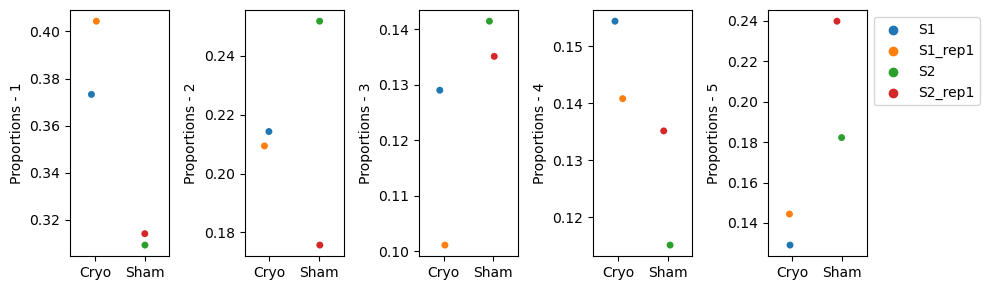

In [44]:
#counts, props, prop_trans = get_transformed_props(adata_rep, sample_col='sample', cluster_col='Clustering (fine)')

counts = data['sim_2']['counts']
props = data['sim_2']['props']
fig, axes = plt.subplots(nrows=1, ncols=len(out.index), figsize=(10, 3))
axes = axes.flatten()
x = np.repeat(pd.unique(adata.obs.Type.to_list()), 2)
for i, cluster in enumerate(props.columns):
    legend = True if i == len(axes) -1 else False
    ax = sns.stripplot(data=props, y=cluster, x=x, hue='sample', legend=legend, jitter=True, ax=axes[i])
    ax.set(ylabel='Proportions - ' + cluster)

ax.legend()
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
fig.tight_layout()

#### Using only simulated replicates -> 2 samples

In [45]:
res_3, data_3 = sim_reps(counts_norep_t, true_props, 2, a_prop, b_prop_grps, conds_reps, n_sim=20, merge=False, cofactor=None)

/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract

In [46]:
# newer sim
res_3

,1,2,3,4,5,pass
sim_1,0.177407,0.131205,0.131205,0.008566,0.131205,False
sim_2,0.247143,0.247143,0.247143,0.190385,0.029086,False
sim_3,0.009783,0.935795,0.935795,0.935795,0.00971,False
sim_4,0.303321,0.130686,0.303321,0.442753,0.334197,True
sim_5,0.252189,0.075951,0.076137,0.004685,0.000665,False
sim_6,0.058913,0.058913,0.183182,0.035079,0.071196,False
sim_7,0.791392,0.791392,0.816906,0.923297,0.791392,True
sim_8,0.034288,0.062205,0.467766,0.494205,0.043058,False
sim_9,0.638266,0.637745,0.540886,0.089502,0.289937,True
sim_10,0.187495,0.863657,0.863657,0.252853,0.021343,False


In [47]:
res_3['pass'].value_counts()

False    13
True      7
Name: pass, dtype: int64

#### New method; With props from each cluster in all samples

In [48]:
# fitting done on sum of cells in each sample
# alpha is estimated from proportion of each cluster in all samples,
# beta calculated from proportion of each cluster in all samples
res_4, data_4 = sim_reps(counts_norep_t, true_props, 1, a_prop_2, b_prop_grps_22, conds_reps, n_sim=20, merge=True, cofactor=None, replicated=True)

/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract

In [49]:
res_4

,1,2,3,4,5,pass
sim_1,0.37952,0.37952,0.66427,0.023528,0.023528,False
sim_2,0.648089,0.648089,0.823967,0.422392,0.138153,True
sim_3,0.939428,0.896061,0.609007,0.01802,0.16121,False
sim_4,0.129735,0.163161,0.778514,0.245459,0.180093,True
sim_5,0.028008,0.028008,0.981264,0.025015,0.025015,False
sim_6,0.483769,0.83238,0.483769,0.426375,0.042679,False
sim_7,0.44186,0.645936,0.481507,0.44186,0.44186,True
sim_8,0.348473,0.082466,0.631552,0.006271,0.022394,False
sim_9,0.335934,0.790616,0.17758,0.168054,0.011877,False
sim_10,0.20897,0.20897,0.704367,0.005814,0.005814,False


In [50]:
res_4['pass'].value_counts()

False    14
True      6
Name: pass, dtype: int64

In [52]:
# only simulated reps
res_5, data_5 = sim_reps(counts_norep_t, true_props, 2, a_prop_2, b_prop_grps_22, conds_reps, n_sim=20, merge=False, cofactor=None, replicated=True)

/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract

In [53]:
res_5

,1,2,3,4,5,pass
sim_1,0.423153,0.423153,0.934811,0.593588,0.593588,True
sim_2,0.776133,0.776133,0.201929,0.126266,0.402795,True
sim_3,0.285922,0.189124,0.781884,0.285922,0.781884,True
sim_4,0.567477,0.208609,0.800849,0.567477,0.914813,True
sim_5,0.906569,0.906569,0.906569,0.115527,0.115527,True
sim_6,0.92593,0.945581,0.92593,0.115111,0.115111,True
sim_7,0.839767,0.686158,0.839767,0.184239,0.086321,True
sim_8,0.046573,0.449676,0.449676,0.656825,0.059351,False
sim_9,0.040793,0.405551,0.102183,0.102183,0.014859,False
sim_10,0.391503,0.391503,0.391503,0.266832,0.391503,True


In [54]:
res_5['pass'].value_counts()

True     16
False     4
Name: pass, dtype: int64

In [55]:
# alpha is estimated from props from each cluster in each sample,
# beta calculated from proportion of each cluster in all samples (using alpha estimation from each cluster in each sample)
res_6, data_6 = sim_reps(counts_norep_t, true_props, 1, a_prop, b_prop_grps_2, conds_reps, n_sim=20, merge=True, cofactor=None, replicated=True)

/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract

In [56]:
res_6

,1,2,3,4,5,pass
sim_1,0.102895,0.192611,0.872844,0.102895,0.102895,True
sim_2,0.118043,0.273755,0.449775,0.346004,0.273755,True
sim_3,0.882607,0.882607,0.882607,0.882607,0.882607,True
sim_4,0.020881,0.073638,0.281894,0.011212,0.020881,False
sim_5,0.113466,0.236283,0.77842,0.028636,0.028636,False
sim_6,0.123708,0.881921,0.45065,0.008492,0.003264,False
sim_7,0.526976,0.897421,0.897421,0.082888,0.049069,False
sim_8,0.146374,0.130932,0.292674,0.130932,0.292674,True
sim_9,0.386679,0.363002,0.908855,0.344862,0.344862,True
sim_10,0.609173,0.609173,0.347972,0.13985,0.286136,True


In [57]:
res_6['pass'].value_counts()

True     10
False    10
Name: pass, dtype: int64

In [58]:
# only simulated counts
res_7, data_7 = sim_reps(counts_norep_t, true_props, 2, a_prop, b_prop_grps_2, conds_reps, n_sim=20, merge=False, cofactor=None, replicated=True)

/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract

In [59]:
res_7

,1,2,3,4,5,pass
sim_1,0.34635,0.066549,0.317944,0.066549,0.086372,True
sim_2,0.43713,0.43713,0.671778,0.43713,0.43713,True
sim_3,0.993113,0.738465,0.576287,0.277484,0.277484,True
sim_4,0.874354,0.874354,0.874354,0.874354,0.777572,True
sim_5,0.377278,0.527233,0.921267,0.527233,0.377278,True
sim_6,0.602051,0.857445,0.931849,0.032499,0.032499,False
sim_7,0.278564,0.850944,0.850944,0.43227,0.066652,True
sim_8,0.402472,0.888528,0.695367,0.402472,0.402472,True
sim_9,0.020328,0.512813,0.512813,0.550418,0.009494,False
sim_10,0.213082,0.759362,0.812037,0.493418,0.225922,True


In [60]:
res_7['pass'].value_counts()

True     14
False     6
Name: pass, dtype: int64

In [62]:
# alpha is estimated from props from each cluster in each sample,
# beta calculated from proportion of each cluster in all samples (using alpha estimation from each cluster in all samples)
res_8, data_8 = sim_reps(counts_norep_t, true_props, 1, a_prop, b_prop_grps_22, conds_reps, n_sim=20, merge=True, cofactor=None, replicated=True)

/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract

In [63]:
res_8

,1,2,3,4,5,pass
sim_1,0.73648,0.942346,0.73648,0.942346,0.73648,True
sim_2,0.426501,0.63519,0.426501,0.426501,0.426501,True
sim_3,0.684433,0.684433,0.720821,0.262688,0.262688,True
sim_4,0.534144,0.534144,0.534144,0.534144,0.534144,True
sim_5,0.830889,0.830889,0.830889,0.830889,0.830889,True
sim_6,0.851886,0.851886,0.851886,0.851886,0.851886,True
sim_7,0.759285,0.759285,0.759285,0.759285,0.759285,True
sim_8,0.902055,0.983951,0.974176,0.902055,0.568033,True
sim_9,0.750647,0.865488,0.750647,0.272652,0.272652,True
sim_10,0.966991,0.966991,0.966991,0.966991,0.966991,True


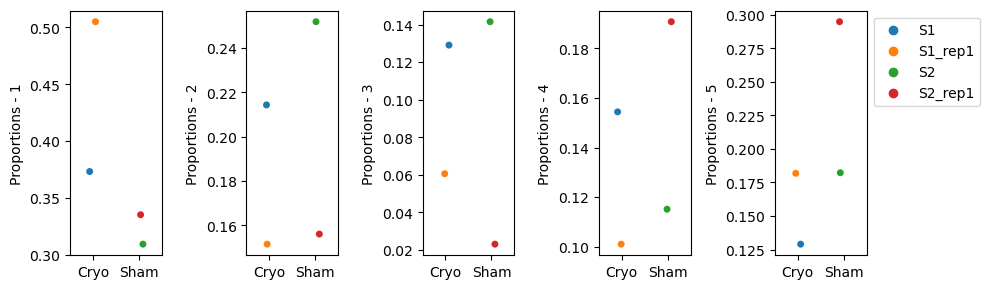

In [64]:
counts = data_8['sim_1']['counts']
props = data_8['sim_1']['props']
fig, axes = plt.subplots(nrows=1, ncols=len(out.index), figsize=(10, 3))
axes = axes.flatten()
x = np.repeat(pd.unique(adata.obs.Type.to_list()), 2)
for i, cluster in enumerate(props.columns):
    legend = True if i == len(axes) -1 else False
    ax = sns.stripplot(data=props, y=cluster, x=x, hue='sample', legend=legend, jitter=True, ax=axes[i])
    ax.set(ylabel='Proportions - '+cluster)

ax.legend()
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
fig.tight_layout()

### rep_1 and rep_2 merged with S1 and S2

In [119]:
props_merged

Clustering (fine),1,2,3,4,5
sample,,,,,
S1,0.353798,0.208117,0.134235,0.181061,0.122789
S2,0.333721,0.259302,0.209302,0.082558,0.115116


In [120]:
counts_merged

Clustering (fine),1,2,3,4,5
sample,,,,,
S1,340,200,129,174,118
S2,287,223,180,71,99


In [65]:
# get true props for each cluster in each sample
groups_props = []
for group in props_merged.T.columns:
    groups_props.append(np.array(props_merged.T[group].to_list()))
grp1_trueprops_merged = groups_props[0]
grp2_trueprops_merged = groups_props[1]

# estimate beta paramters from proportions
a_prop_merged, b_prob_merged = estimate_beta_params(props_merged.T)  # rows are clusters

# get proportions of each cluster in all samples
counts_merged_t = counts_merged.T
# total sum per row and column
counts_merged_t.loc['sum',:]= counts_merged_t.sum(axis=0)
#Total sum per row: 
counts_merged_t.loc[:,'sum'] = counts_merged_t.sum(axis=1)
true_props_merged = counts_merged_t.iloc[:,-1].div(counts_merged_t["sum"][-1], axis=0)  # sum of cells in cluster / sum of all cells
true_props_merged = true_props_merged.iloc[:-1].to_frame(name="props")

# get props for each cluster in each sample
true_props_merged_2 = counts_merged_t.iloc[:,:-1].div(counts_merged_t["sum"][-1], axis=0)
true_props_merged_2 = true_props_merged_2.iloc[:-1,:]

# estimate parameters from proportions of each cluster in each sample compared to all samples
a_prop_merged_2, b_prob_merged_2 = estimate_beta_params(true_props_merged_2)  # rows are clusters

counts_merged_t = counts_merged_t.iloc[:-1,:-1]

# calculate beta for each sample
b1_prop_merged = a_prop_merged*(1-grp1_trueprops_merged)/grp1_trueprops_merged
b2_prop_merged = a_prop_merged*(1-grp2_trueprops_merged)/grp2_trueprops_merged

b_prop_grps_merged = [b1_prop_merged.values,b2_prop_merged.values]

# new method
grp1_trueprops_merged_2 = true_props_merged_2.iloc[:,0].values
grp2_trueprops_merged_2 = true_props_merged_2.iloc[:,1].values

# using alpha from first estimation
b1_prop_merged_2 = a_prop_merged*(1-grp1_trueprops_merged_2)/grp1_trueprops_merged_2
b2_prop_merged_2 = a_prop_merged*(1-grp2_trueprops_merged_2)/grp2_trueprops_merged_2
b_prop_grps_merged_2 = [b1_prop_merged_2.values,b2_prop_merged_2.values]

# using alpha from second estimation
b1_prop_merged_22 = a_prop_merged_2*(1-grp1_trueprops_merged_2)/grp1_trueprops_merged_2
b2_prop_merged_22 = a_prop_merged_2*(1-grp2_trueprops_merged_2)/grp2_trueprops_merged_2

b_prop_grps_merged_22 = [b1_prop_merged_22.values,b2_prop_merged_22.values]

In [66]:
true_props_merged_2

sample,S1,S2
Clustering (fine),,
1,0.186711,0.157606
2,0.109830,0.122460
3,0.070840,0.098847
4,0.095552,0.038990
5,0.064800,0.054366


In [67]:
n_reps = 1
conds_reps = np.repeat(adata_merged.obs.Type.unique().to_list(), n_reps)
conds_reps

array(['Cryo', 'Sham'], dtype='<U4')

#### simulation with 1 replicate each

In [68]:
# fitting done on sum of cells in each sample
res_dist, matrices = sim_reps(counts_merged_t, true_props_merged, n_reps, a_prop_merged, b_prop_grps_merged, conds_reps, n_sim=20, merge=True, cofactor=None)

/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract

In [69]:
# newer sim
res_dist

,1,2,3,4,5,pass
sim_1,0.816709,0.202642,0.816709,0.125442,0.816709,True
sim_2,0.974274,0.204263,0.54813,0.015558,0.54813,False
sim_3,0.885439,0.885439,0.885439,0.885439,0.885439,True
sim_4,0.878696,0.039009,0.023722,0.000376,0.878696,False
sim_5,0.842839,0.842839,0.842839,0.842839,0.946608,True
sim_6,0.741295,0.000123,0.000016,0.0,0.320669,False
sim_7,0.465437,0.127922,0.021295,0.000049,0.438953,False
sim_8,0.299464,0.006388,0.008947,0.000847,0.555419,False
sim_9,0.65473,0.65473,0.381133,0.017799,0.65473,False
sim_10,0.581502,0.179873,0.004117,0.000131,0.581502,False


In [70]:
res_dist['pass'].value_counts()

False    15
True      5
Name: pass, dtype: int64

In [71]:
# only simulated counts
res_dist_2, matrices_2 = sim_reps(counts_merged_t, true_props_merged, 2, a_prop_merged, b_prop_grps_merged, conds_reps, n_sim=20, merge=False, cofactor=None)

/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract

In [72]:
res_dist_2

,1,2,3,4,5,pass
sim_1,0.445397,0.332182,0.086619,0.000641,0.685734,False
sim_2,0.922501,0.020446,0.020446,0.001081,0.551269,False
sim_3,0.785327,0.634337,0.382727,0.002908,0.382727,False
sim_4,0.711349,0.376247,0.376247,0.376247,0.735183,True
sim_5,0.778204,0.286616,0.000767,0.010876,0.013099,False
sim_6,0.766194,0.42205,0.578905,0.025099,0.997962,False
sim_7,0.950729,0.417212,0.094023,0.022209,0.853398,False
sim_8,0.444164,0.463087,0.010489,0.010489,0.442926,False
sim_9,0.55763,0.201416,0.002938,0.001464,0.955139,False
sim_10,0.910874,0.910874,0.910874,0.910874,0.910874,True


In [73]:
res_dist_2['pass'].value_counts()

False    14
True      6
Name: pass, dtype: int64

In [74]:
res_dist_3, matrices_3 = sim_reps(counts_merged_t, true_props_merged, 1, a_prop_merged, b_prop_grps_merged_2, conds_reps, n_sim=20, merge=True, cofactor=None)

/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract

In [75]:
res_dist_3

,1,2,3,4,5,pass
sim_1,0.926718,0.132318,0.132318,0.005227,0.926718,False
sim_2,0.608271,0.098446,0.048832,0.02464,0.608271,False
sim_3,0.498217,0.103273,0.070115,0.055889,0.404784,True
sim_4,0.927464,0.927464,0.927464,0.927464,0.927464,True
sim_5,0.962736,0.962736,0.371887,0.515815,0.962736,True
sim_6,0.890223,0.77283,0.842238,0.77283,0.814652,True
sim_7,0.297924,0.269877,0.007669,0.020338,0.297924,False
sim_8,0.758462,0.595862,0.01663,0.000527,0.758462,False
sim_9,0.71046,0.671882,0.613878,0.059944,0.71046,True
sim_10,0.65201,0.088443,0.023739,0.000235,0.52413,False


In [76]:
res_dist_3['pass'].value_counts()

False    13
True      7
Name: pass, dtype: int64

In [79]:
# only simulated counts
res_dist_4, matrices_4 = sim_reps(counts_merged_t, true_props_merged, 2, a_prop_merged, b_prop_grps_merged_2, conds_reps, n_sim=20, merge=False, cofactor=None)

/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract

In [80]:
res_dist_4

,1,2,3,4,5,pass
sim_1,0.45074,0.999826,0.426113,0.999826,0.426113,True
sim_2,0.340135,0.278363,0.007073,0.002595,0.340135,False
sim_3,0.867182,0.28689,0.867182,0.28689,0.867182,True
sim_4,0.924928,0.49773,0.317528,0.317528,0.317528,True
sim_5,0.540626,0.353838,0.019343,0.000101,0.789939,False
sim_6,0.901571,0.130279,0.298453,0.002672,0.901571,False
sim_7,0.727613,0.001669,0.711058,0.00012,0.727613,False
sim_8,0.548332,0.199673,0.011456,0.011456,0.199673,False
sim_9,0.320261,0.136735,0.136735,0.151865,0.320261,True
sim_10,0.705291,0.48974,0.267043,0.016641,0.705291,False


In [81]:
res_dist_4['pass'].value_counts()

False    11
True      9
Name: pass, dtype: int64

In [83]:
# alpha and beta from second estimation and new method
res_dist_5, matrices_5 = sim_reps(counts_merged_t, true_props_merged, 1, a_prop_merged_2, b_prop_grps_merged_22, conds_reps, n_sim=20, merge=True, cofactor=None)

/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract

In [84]:
res_dist_5

,1,2,3,4,5,pass
sim_1,0.591389,0.226525,0.411306,0.128125,0.92755,True
sim_2,0.835065,0.144961,0.137658,0.137658,0.167227,True
sim_3,0.424194,0.424194,0.062227,0.125182,0.706719,True
sim_4,0.496744,0.102977,0.15331,0.041799,0.496744,False
sim_5,0.743434,0.063611,0.002387,0.002104,0.283254,False
sim_6,0.239685,0.239685,0.020409,0.025721,0.642754,False
sim_7,0.801413,0.801413,0.801413,0.801413,0.801413,True
sim_8,0.809967,0.368592,0.004266,0.000662,0.696219,False
sim_9,0.161471,0.161471,0.161471,0.245741,0.245741,True
sim_10,0.633157,0.128799,0.01156,0.000329,0.660049,False


In [85]:
res_dist_5['pass'].value_counts()

False    13
True      7
Name: pass, dtype: int64

In [86]:
# alpha and beta from second estimation and new method
res_dist_6, matrices_6 = sim_reps(counts_merged_t, true_props_merged, 2, a_prop_merged_2, b_prop_grps_merged_22, conds_reps, n_sim=20, merge=False, cofactor=None)

/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract

In [87]:
res_dist_6

,1,2,3,4,5,pass
sim_1,0.892057,0.080026,0.0047,0.000074,0.916851,False
sim_2,0.220133,0.144988,0.081424,0.081424,0.936655,True
sim_3,0.967519,0.967519,0.843202,0.967519,0.843202,True
sim_4,0.267474,0.267474,0.524061,0.018258,0.655635,False
sim_5,0.915721,0.915721,0.612226,0.612226,0.936729,True
sim_6,0.721129,0.41932,0.040026,0.004622,0.721129,False
sim_7,0.756447,0.487405,0.112537,0.012329,0.997221,False
sim_8,0.644896,0.644896,0.644896,0.644896,0.644896,True
sim_9,0.852928,0.852928,0.032569,0.064113,0.797049,False
sim_10,0.925765,0.745181,0.745181,0.106497,0.925765,True


In [88]:
res_dist_6['pass'].value_counts()

True     12
False     8
Name: pass, dtype: int64

In [91]:
# alpha and beta from second estimation and new method
res_dist_7, matrices_7 = sim_reps(counts_merged_t, true_props_merged, 1, a_prop_merged, b_prop_grps_merged_22, conds_reps, n_sim=20, merge=True, cofactor=None)

/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract

In [92]:
res_dist_7

,1,2,3,4,5,pass
sim_1,0.968561,0.968561,0.968561,0.968561,0.968561,True
sim_2,0.994058,0.994058,0.994058,0.994058,0.994058,True
sim_3,0.972124,0.972124,0.972124,0.972124,0.972124,True
sim_4,0.989975,0.989975,0.989975,0.989975,0.989975,True
sim_5,0.971446,0.971446,0.940119,0.940119,0.971446,True
sim_6,0.963914,0.963914,0.963914,0.963914,0.963914,True
sim_7,0.993675,0.993675,0.993675,0.993675,0.993675,True
sim_8,0.951853,0.951853,0.951853,0.951853,0.951853,True
sim_9,0.972892,0.972892,0.943902,0.717581,0.972892,True
sim_10,0.939537,0.939537,0.939537,0.939537,0.939537,True


In [93]:
matrices_7['sim_1']['props']

Clustering (fine),1,2,3,4,5
sample,,,,,
S1,0.353798,0.208117,0.134235,0.181061,0.122789
S1_rep1,0.560311,0.022374,0.034047,0.085603,0.297665
S2,0.333721,0.259302,0.209302,0.082558,0.115116
S2_rep1,0.565350,0.034448,0.051672,0.064843,0.283688


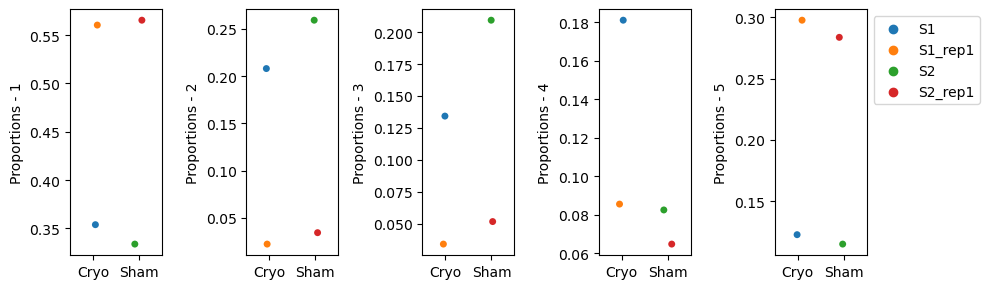

In [94]:
#counts, props, prop_trans = get_transformed_props(adata_rep, sample_col='sample', cluster_col='Clustering (fine)')

counts = matrices_7['sim_1']['counts']
props = matrices_7['sim_1']['props']
fig, axes = plt.subplots(nrows=1, ncols=len(out.index), figsize=(10, 3))
axes = axes.flatten()
x = np.repeat(pd.unique(adata.obs.Type.to_list()), 2)
for i, cluster in enumerate(props.columns):
    legend = True if i == len(axes) -1 else False
    ax = sns.stripplot(data=props, y=cluster, x=x, hue='sample', legend=legend, jitter=True, ax=axes[i])
    ax.set(ylabel='Proportions - '+cluster)
    #ax.legend()
    #plt.axline(xy1=(0, fit_props['coefficients'][0][0]), slope=fit_props['coefficients'][1][0])

ax.legend()
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
fig.tight_layout()

## Bootstrapping original samples into multiple samples

The Idea is to reduce number of cells in all samples to match the sample with the minimum number of cells (n_min) by choosing
(n_min) random cells from each sample. Next step is splitting each sample into two by bootstrapping without resampling

In [95]:
def split_boot_reps(adata, n_boots=10, samples='sample'):
    groups = adata.obs[samples].unique()
    groups_adatas = {}
    for group in groups:
        groups_adatas[group] = (adata[adata.obs[samples] == group])  # subset data for each sample
    indices = {}
    for i, group in enumerate(groups_adatas.keys()):
        indices[groups[i]] = np.arange(groups_adatas[group].shape[0])  # get sequence of indices
    n_min = [min([len(indices[groups[i]]) for i, _ in enumerate(groups_adatas.keys())])][0]
    reps = []
    for group in groups:
        reduce = np.random.choice(indices[group], n_min, replace=False)
        groups_adatas[group] = groups_adatas[group][reduce]
        n = n_min
        n_indices = np.arange(n)
        n_1 = np.random.choice(range(n), replace=False)  # number of cells for rep 1
        n_2 = n - n_1  # number of cells for rep 2
        #np.random.shuffle(indices[group])
        rep_1_indices = np.random.choice(n_indices, n_1, replace=False)
        rep_2_indices = [i for i in n_indices if i not in rep_1_indices]
        rep_1 = groups_adatas[group][rep_1_indices]
        rep_2 = groups_adatas[group][rep_2_indices]
        rep_1.obs[samples] = [group+'_rep_'+str(1)]*rep_1.shape[0]
        rep_2.obs[samples] = [group+'_rep_'+str(2)]*rep_2.shape[0]

        rep_1.obs_names_make_unique()
        rep_2.obs_names_make_unique()
        reps.append(rep_1)
        reps.append(rep_2)
    
    return reps

### Example run using merged samples

In [96]:
reps = split_boot_reps(adata_merged, samples='sample')

In [97]:
adata_split_rep = reps[0].concatenate(reps[1:], join='outer')
adata_split_rep.obs_names_make_unique()
adata_split_rep

AnnData object with n_obs × n_vars = 1720 × 13910
    obs: 'Type', 'Chip', 'Detected genes', 'Total counts', 'Clustering (fine)', 'sample', 'batch'
    var: 'ensembl_gene_id', 'external_gene_name', 'gene_biotype', 'description', 'is_mito', 'n_cells_by_counts', 'log1p_mean_counts', 'mean_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts', 'tpm'

In [98]:
pypropeller.pypropeller(adata_split_rep, clusters='Clustering (fine)', sample='sample', cond='Type', transform='logit')

There are 2 conditions. T-Test will be performed...
Done!


,Baseline_props,Mean_props_Cryo,Mean_props_Sham,Prop_ratio,t_statistics,p_values,Adjusted_p_values
Clusters,,,,,,,
1,0.344186,0.341108,0.344487,0.990192,-0.074669,0.941951,0.941951
2,0.235465,0.221657,0.247620,0.895151,-0.707703,0.495293,0.619116
3,0.169186,0.133888,0.208648,0.641694,-2.654662,0.024119,0.060298
4,0.131395,0.180821,0.092534,1.954104,4.009244,0.002481,0.012405
5,0.119767,0.122525,0.106710,1.148196,0.865312,0.407148,0.619116


In [99]:
adata_split_rep.obs['sample'].value_counts()

S1_rep_1    684
S2_rep_1    604
S2_rep_2    256
S1_rep_2    176
Name: sample, dtype: int64

### Example run using anndata with s1_rep & s2_rep removed

In [100]:
reps_2 = split_boot_reps(adata_norep, samples='sample')
adata_split_rep_2 = reps_2[0].concatenate(reps[1:], join='outer')
adata_split_rep_2.obs_names_make_unique()
adata_split_rep_2

AnnData object with n_obs × n_vars = 1116 × 13910
    obs: 'Type', 'Chip', 'Detected genes', 'Total counts', 'Clustering (fine)', 'sample', 'batch'
    var: 'ensembl_gene_id', 'external_gene_name', 'gene_biotype', 'description', 'is_mito', 'n_cells_by_counts', 'log1p_mean_counts', 'mean_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts', 'tpm'

In [101]:
pypropeller.pypropeller(adata_split_rep_2, clusters='Clustering (fine)', sample='sample', cond='Type', transform='logit')

There are 2 conditions. T-Test will be performed...
Done!


,Baseline_props,Mean_props_Cryo,Mean_props_Sham,Prop_ratio,t_statistics,p_values,Adjusted_p_values
Clusters,,,,,,,
1,0.339606,0.384091,0.344487,1.114964,0.685711,0.508480,0.635600
2,0.248208,0.194318,0.247620,0.784743,-1.482531,0.169013,0.281688
3,0.193548,0.139773,0.208648,0.669897,-2.188629,0.053460,0.133649
4,0.114695,0.172159,0.092534,1.860493,3.408065,0.006680,0.033400
5,0.103943,0.109659,0.106710,1.027632,0.273345,0.790151,0.790151


### Simulation using merged samples

In [102]:
n_sims = 10
res = {f'sim_{i+1}': {} for i in range(n_sims)}
adatas = {f'sim_{i+1}': {} for i in range(n_sims)}
for i in range(n_sims):
    reps = split_boot_reps(adata_merged, samples='sample')
    adata_split_rep = reps[0].concatenate(reps[1:], join='outer')
    adata_split_rep.obs_names_make_unique()
    adatas[f'sim_{i+1}'] = adata_split_rep
    out = pypropeller.pypropeller(adata_split_rep, clusters='Clustering (fine)', sample='sample', cond='Type', transform='logit')
    for k, cluster in enumerate(out.index):
        res[f'sim_{i+1}'][cluster] = out.iloc[k,-1]
for i in range(n_sims):
    res[f'sim_{i+1}']['pass'] = res[f'sim_{i+1}']['1'] > 0.05 and res[f'sim_{i+1}']['2'] > 0.05 and res[f'sim_{i+1}']['3'] > 0.05 and res[f'sim_{i+1}']['4'] > 0.05 and res[f'sim_{i+1}']['5'] > 0.05

res = pd.DataFrame(res).T

There are 2 conditions. T-Test will be performed...
Done!
There are 2 conditions. T-Test will be performed...
Done!
There are 2 conditions. T-Test will be performed...
Done!
There are 2 conditions. T-Test will be performed...
Done!
There are 2 conditions. T-Test will be performed...
Done!
There are 2 conditions. T-Test will be performed...
Done!
There are 2 conditions. T-Test will be performed...
Done!
There are 2 conditions. T-Test will be performed...
Done!
There are 2 conditions. T-Test will be performed...
Done!
There are 2 conditions. T-Test will be performed...
Done!


In [103]:
res

,1,2,3,4,5,pass
sim_1,0.824701,0.107599,0.107599,0.01565,0.212975,False
sim_2,0.615437,0.029294,0.001026,0.000012,0.615437,False
sim_3,0.304801,0.037666,0.001952,0.000036,0.772665,False
sim_4,0.335155,0.035085,0.001044,0.000098,0.41152,False
sim_5,0.675986,0.03133,0.000216,0.000002,0.856842,False
sim_6,0.438367,0.008927,0.003036,0.000042,0.579497,False
sim_7,0.785896,0.048634,0.021307,0.000079,0.532896,False
sim_8,0.867761,0.266381,0.523474,0.266381,0.303982,True
sim_9,0.431583,0.199244,0.052363,0.00304,0.431583,False
sim_10,0.560155,0.109057,0.009115,0.000396,0.560155,False


### Simulation using anndata with s1_rep & s2_rep removed

In [104]:
n_sims = 10
res = {f'sim_{i+1}': {} for i in range(n_sims)}
adatas = {f'sim_{i+1}': {} for i in range(n_sims)}
for i in range(n_sims):
    reps = split_boot_reps(adata_norep, samples='sample')
    adata_split_rep = reps[0].concatenate(reps[1:], join='outer')
    adata_split_rep.obs_names_make_unique()
    adatas[f'sim_{i+1}'] = adata_split_rep
    out = pypropeller.pypropeller(adata_split_rep, clusters='Clustering (fine)', sample='sample', cond='Type', transform='logit')
    for k, cluster in enumerate(out.index):
        res[f'sim_{i+1}'][cluster] = out.iloc[k,-1]
for i in range(n_sims):
    res[f'sim_{i+1}']['pass'] = res[f'sim_{i+1}']['1'] > 0.05 and res[f'sim_{i+1}']['2'] > 0.05 and res[f'sim_{i+1}']['3'] > 0.05 and res[f'sim_{i+1}']['4'] > 0.05 and res[f'sim_{i+1}']['5'] > 0.05

res = pd.DataFrame(res).T

There are 2 conditions. T-Test will be performed...
Done!
There are 2 conditions. T-Test will be performed...
Done!
There are 2 conditions. T-Test will be performed...
Done!
There are 2 conditions. T-Test will be performed...
Done!
There are 2 conditions. T-Test will be performed...
Done!
There are 2 conditions. T-Test will be performed...
Done!
There are 2 conditions. T-Test will be performed...
Done!
There are 2 conditions. T-Test will be performed...
Done!
There are 2 conditions. T-Test will be performed...
Done!
There are 2 conditions. T-Test will be performed...
Done!


In [105]:
res

,1,2,3,4,5,pass
sim_1,0.094432,0.162066,0.162066,0.162066,0.094432,True
sim_2,0.917147,0.917147,0.917147,0.917147,0.382907,True
sim_3,0.114529,0.114529,0.96891,0.113149,0.106148,True
sim_4,0.108807,0.250983,0.367022,0.038734,0.028887,False
sim_5,0.105331,0.445803,0.505194,0.105331,0.022103,False
sim_6,0.187391,0.221606,0.910503,0.154675,0.117841,True
sim_7,0.544196,0.848463,0.848463,0.848463,0.395636,True
sim_8,0.428412,0.75238,0.655259,0.369123,0.065845,True
sim_9,0.29019,0.314626,0.839475,0.396414,0.105406,True
sim_10,0.456267,0.573525,0.967585,0.456267,0.361499,True


In [106]:
adata_norep.obs['sample'].value_counts()

S1    434
S2    417
Name: sample, dtype: int64

In [107]:
adatas['sim_1'].obs['sample'].value_counts()

S1_rep_1    371
S2_rep_2    334
S2_rep_1     83
S1_rep_2     46
Name: sample, dtype: int64

# Artificial data from propeller vignette
* This is a simulated dataset where cells proportions in clusters don't differ accross groups.
* Adjusted p-values for original dataset are:
    - H1975: 0.050034
    - H2228: 0.050034
    - HCC827: 0.812453

In [ ]:
adata_norep = sc.read_h5ad('/mnt/workspace/yalayou/scATAC_seq/framework/data/thesis/data/propeller_tutorial_noRep.h5ad')
adata_norep

/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 1401 × 13575
    obs: 'sample', 'group', 'cluster'
    uns: 'color_set', 'infoprocess'

In [ ]:
len(pd.unique(adata_norep.obs.group.to_list()))

3

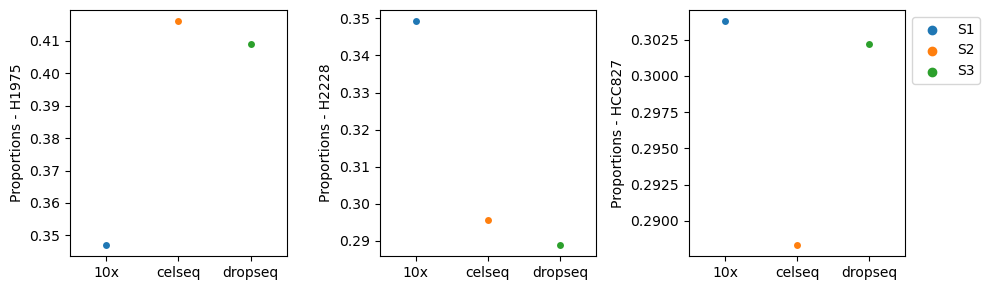

In [ ]:
counts, props, prop_trans = get_transformed_props(adata_norep, sample_col='sample', cluster_col='cluster')

fig, axes = plt.subplots(nrows=1, ncols=len(out.index), figsize=(10, 3))
axes = axes.flatten()
x = np.repeat(pd.unique(adata_norep.obs.group.to_list()), 1)
for i, cluster in enumerate(props.columns):
    legend = True if i == len(axes) -1 else False
    ax = sns.stripplot(data=props, y=cluster, x=x, hue='sample', legend=legend, jitter=True, ax=axes[i])
    ax.set(ylabel='Proportions - '+cluster)

ax.legend()
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
fig.tight_layout()

In [ ]:
counts_norep, props_norep, prop_trans_norep = get_transformed_props(adata_norep, sample_col='sample', cluster_col='cluster', transform='logit')
baseline_props_norep = adata_norep.obs['cluster'].value_counts()/adata_norep.obs.shape[0]  # proportions of each cluster in all samples
props_norep

cluster,H1975,H2228,HCC827
sample,,,
S1,0.347007,0.349224,0.303769
S2,0.416058,0.295620,0.288321
S3,0.408889,0.288889,0.302222


## Bootstrapping with replacement

In [ ]:
def sim_boot_reps(adata, n_sims=20, n_boots=2, clusters='cluster', conds='group', samples='sample'):
    import warnings
    import anndata
    warnings.simplefilter(action='ignore', category=FutureWarning)
    warnings.simplefilter(action='ignore', category=anndata.ImplicitModificationWarning)
    warnings.simplefilter(action='ignore', category=UserWarning)

    # create dict for simulation results
    res = {f'sim_{i+1}': {} for i in range(n_sims)}
    adatas = {f'sim_{i+1}': {} for i in range(n_sims)}
    for i in range(n_sims):
        reps = boot_reps(adata, n_boots=n_boots, samples=samples)
        adata_rep = adata.concatenate(reps, join='outer')
        adata_rep.obs_names_make_unique()
        adatas[f'sim_{i+1}'] = adata_rep
        out = pypropeller.pypropeller(adata_rep, clusters=clusters, sample=samples, cond=conds, transform='logit')
        for k, cluster in enumerate(out.index):
            res[f'sim_{i+1}'][cluster] = out.iloc[k,-1]
    for i in range(n_sims):
        res[f'sim_{i+1}']['pass'] = res[f'sim_{i+1}']['H1975'] > 0.05 and res[f'sim_{i+1}']['H2228'] > 0.05 and res[f'sim_{i+1}']['HCC827'] > 0.05

    res = pd.DataFrame(res).T
    
    return res, adatas, adata_rep

### Removed replicates

In [ ]:
n_sims = 10
res, adatas, rep_adata = sim_boot_reps(adata_norep, n_sims=n_sims, n_boots=1, clusters='cluster', conds='group', samples='sample')

There are more than 2 conditions. ANOVA will be performed...
Done!
There are more than 2 conditions. ANOVA will be performed...
Done!
There are more than 2 conditions. ANOVA will be performed...
Done!
There are more than 2 conditions. ANOVA will be performed...
Done!
There are more than 2 conditions. ANOVA will be performed...
Done!
There are more than 2 conditions. ANOVA will be performed...
Done!
There are more than 2 conditions. ANOVA will be performed...
Done!
There are more than 2 conditions. ANOVA will be performed...
Done!
There are more than 2 conditions. ANOVA will be performed...
Done!
There are more than 2 conditions. ANOVA will be performed...
Done!


In [ ]:
res

,H1975,H2228,HCC827,pass
sim_1,0.000018,0.000178,0.526615,False
sim_2,0.008402,0.040529,0.146114,False
sim_3,0.000244,0.000179,0.034978,False
sim_4,0.024533,0.002668,0.655609,False
sim_5,0.00001,0.000034,0.047879,False
sim_6,0.0,0.0,0.441525,False
sim_7,0.0,0.000006,0.100939,False
sim_8,0.0,0.0,0.104906,False
sim_9,0.000179,0.02766,0.153096,False
sim_10,0.005005,0.142035,0.174184,False


In [ ]:
rep_adata.obs['sample'].value_counts()

S1          902
S1_rep_1    902
S2          274
S2_rep_1    274
S3          225
S3_rep_1    225
Name: sample, dtype: int64

### Merged replicates

In [ ]:
adata.obs.group.unique()

['10x', 'celseq', 'dropseq']
Categories (3, object): ['10x', 'celseq', 'dropseq']

In [ ]:
adata_norep_merged = adata.copy()
adata_norep_merged.obs['sample'] = adata_norep_merged.obs['group'].map({'10x': 'S1', 'celseq': 'S2', 'dropseq': 'S3'})
adata_norep_merged

AnnData object with n_obs × n_vars = 2802 × 13575
    obs: 'sample', 'group', 'cluster'
    uns: 'color_set', 'infoprocess'

In [ ]:
counts_merged, props_merged, prop_trans_merged = get_transformed_props(adata_norep_merged, sample_col='sample', cluster_col='cluster', transform='logit')
baseline_props_norep = adata_norep.obs['cluster'].value_counts()/adata_norep_merged.obs.shape[0]  # proportions of each cluster in all samples
props_merged

cluster,H1975,H2228,HCC827
sample,,,
S1,0.339246,0.348115,0.312639
S2,0.394161,0.297445,0.308394
S3,0.388889,0.311111,0.300000


In [ ]:
n_sims = 10
res, adatas, rep_adata = sim_boot_reps(adata_norep_merged, n_sims=n_sims, n_boots=1, clusters='cluster', conds='group', samples='sample')

There are more than 2 conditions. ANOVA will be performed...
Done!
There are more than 2 conditions. ANOVA will be performed...
Done!
There are more than 2 conditions. ANOVA will be performed...
Done!
There are more than 2 conditions. ANOVA will be performed...
Done!
There are more than 2 conditions. ANOVA will be performed...
Done!
There are more than 2 conditions. ANOVA will be performed...
Done!
There are more than 2 conditions. ANOVA will be performed...
Done!
There are more than 2 conditions. ANOVA will be performed...
Done!
There are more than 2 conditions. ANOVA will be performed...
Done!
There are more than 2 conditions. ANOVA will be performed...
Done!


In [ ]:
res

,H1975,H2228,HCC827,pass
sim_1,0.0,0.0,0.806197,False
sim_2,0.000167,0.00393,0.491595,False
sim_3,0.0,0.0,0.028458,False
sim_4,0.000052,0.000052,0.465353,False
sim_5,0.048189,0.014914,0.060006,False
sim_6,0.0,0.0,0.153618,False
sim_7,0.000092,0.000322,0.588374,False
sim_8,0.0,0.0,0.06322,False
sim_9,0.000015,0.000001,0.810656,False
sim_10,0.0,0.000066,0.047613,False


## Simulation from distribution

In [ ]:
def sim_reps(counts, props, n_reps, a, b, grp, n_sim=50, merge=True, cofactor=None, replicated=True, n=None, mu=None):
    """Simulate replicates by estimating distribution parameters from data.

    :param _type_ counts: _description_
    :param _type_ props: _description_
    :param _type_ n_reps: _description_
    :param _type_ a: _description_
    :param _type_ b: _description_
    :param _type_ grp: _description_
    :param int n_sim: _description_, defaults to 50
    :param bool merge: _description_, defaults to True
    :param _type_ cofactor: _description_, defaults to None
    :return _type_: _description_
    """
    res = {f'sim_{i+1}': {} for i in range(n_sim)}
    matrices = {f'sim_{i+1}': {} for i in range(n_sim)}
    for i in range(n_sim):
        n_reps_sim = n_reps
        counts_sim = simulate_cell_counts(counts, props, n_reps, a, b, n, mu)
        if merge:
            counts_sim = pd.merge(counts.T.reset_index(), counts_sim.reset_index(), 'outer').set_index('sample')
            n_reps_sim += 1
        props_sim, prop_trans_sim = get_tranformed_props_counts(counts_sim, replicated=replicated)
        props_sim = props_sim.sort_index()
        prop_trans_sim = prop_trans_sim.sort_index()
        
        # save matrices in dict
        matrices[f'sim_{i+1}']['counts'] = counts_sim
        matrices[f'sim_{i+1}']['props'] = props_sim

        conds = np.repeat(pd.unique(grp), n_reps_sim)  # reps = number of replicates + 1
        
        design = create_design(samples=props_sim.index, conds=conds, cofactors=cofactor, reindex=props_sim.index)
        matrices[f'sim_{i+1}']['design'] = design
        coef = np.arange(len(design.columns))
        out = pypropeller.anova(props_sim, prop_trans_sim, design, coef, robust=True)
        for k, cluster in enumerate(out.index):
            res[f'sim_{i+1}'][cluster] = out.iloc[k,-1]
    for i in range(n_sim):
        res[f'sim_{i+1}']['pass'] = res[f'sim_{i+1}']['H1975'] > 0.05 and res[f'sim_{i+1}']['H2228'] > 0.05 and res[f'sim_{i+1}']['HCC827'] > 0.05
    
    res = pd.DataFrame(res).T
    
    return res, matrices

### removed replicates

In [ ]:
props_norep

cluster,H1975,H2228,HCC827
sample,,,
S1,0.347007,0.349224,0.303769
S2,0.416058,0.295620,0.288321
S3,0.408889,0.288889,0.302222


In [ ]:
# get true props for each cluster in each sample
groups_props = []
for group in props_norep.T.columns:
    groups_props.append(np.array(props_norep.T[group].to_list()))
grp1_trueprops = groups_props[0]
grp2_trueprops = groups_props[1]
grp3_trueprops = groups_props[2]

grp1_trueprops

array([0.34700665, 0.34922395, 0.3037694 ])

In [ ]:
# estimate beta paramters from proportions
a_prop, b_prob = estimate_beta_params(props_norep.T)  # rows are clusters

a_prop, b_prob

(cluster
 H1975      64.120086
 H2228      60.724459
 HCC827    861.468003
 dtype: float64,
 cluster
 H1975      100.016279
 H2228      134.377699
 HCC827    2028.353135
 dtype: float64)

In [ ]:
counts_norep_t = counts_norep.T

# total sum per row and column
counts_norep_t.loc['sum',:]= counts_norep_t.sum(axis=0)
#Total sum per row: 
counts_norep_t.loc[:,'sum'] = counts_norep_t.sum(axis=1)
# proportion of each cluster in all samples
true_props = counts_norep_t.iloc[:,-1].div(counts_norep_t["sum"][-1], axis=0)  # sum of cells in cluster / sum of all cells
true_props = true_props.iloc[:-1].to_frame(name="props")
true_props

,props
cluster,
H1975,0.370450
H2228,0.329051
HCC827,0.300500


In [ ]:
# get props for each cluster in all samples
true_props_2 = counts_norep_t.iloc[:,:-1].div(counts_norep_t["sum"][-1], axis=0)
true_props_2 = true_props_2.iloc[:-1,:]
true_props_2

sample,S1,S2,S3
cluster,,,
H1975,0.223412,0.081370,0.065667
H2228,0.224839,0.057816,0.046395
HCC827,0.195575,0.056388,0.048537


In [ ]:
# new method; estimate beta paramters from proportions of each cluster in all samples
a_prop_2, b_prob_2 = estimate_beta_params(true_props_2)  # rows are clusters

a_prop_2, b_prob_2

(cluster
 H1975     1.646524
 H2228     0.963744
 HCC827    1.219296
 dtype: float64,
 cluster
 H1975     11.687462
 H2228      7.822842
 HCC827    10.953390
 dtype: float64)

In [ ]:
counts_norep_t = counts_norep_t.iloc[:-1,:-1]
counts_norep_t

sample,S1,S2,S3
cluster,,,
H1975,313.0,114.0,92.0
H2228,315.0,81.0,65.0
HCC827,274.0,79.0,68.0


In [ ]:
# old method; calculate beta params from proportions of each cluster in each sample -> n_cells in cluster/n_cells in sample
b1_prop = a_prop*(1-grp1_trueprops)/grp1_trueprops
b2_prop = a_prop*(1-grp2_trueprops)/grp2_trueprops
b3_prop = a_prop*(1-grp3_trueprops)/grp3_trueprops

b_prop_grps = [b1_prop.values, b2_prop.values, b3_prop.values]

# new method; calculate beta params from proportions of each cluster in all samples -> n_cells in cluster/n_cells in dataset
grp1_trueprops_2 = true_props_2.iloc[:,0].values
grp2_trueprops_2 = true_props_2.iloc[:,1].values
grp3_trueprops_2 = true_props_2.iloc[:,2].values

# using first estimation of alpha
b1_prop_2 = a_prop*(1-grp1_trueprops_2)/grp1_trueprops_2
b2_prop_2 = a_prop*(1-grp2_trueprops_2)/grp2_trueprops_2
b3_prop_2 = a_prop*(1-grp3_trueprops_2)/grp3_trueprops_2
b_prop_grps_2 = [b1_prop_2.values, b2_prop_2.values, b3_prop_2.values]
# using second estimation of alpha
b1_prop_22 = a_prop_2*(1-grp1_trueprops_2)/grp1_trueprops_2
b2_prop_22 = a_prop_2*(1-grp2_trueprops_2)/grp2_trueprops_2
b3_prop_22 = a_prop_2*(1-grp3_trueprops_2)/grp3_trueprops_2
b_prop_grps_22 = [b1_prop_22.values, b2_prop_22.values, b3_prop_22.values]
b_prop_grps_22


[array([5.72337901, 3.32262239, 5.01513302]),
 array([18.58838436, 15.70545882, 20.40391318]),
 array([23.42716668, 19.80864722, 23.90178523])]

In [ ]:
n_reps = 1
conds_reps = np.repeat(adata_norep_merged.obs.group.unique().to_list(), n_reps)
conds_reps

array(['10x', 'celseq', 'dropseq'], dtype='<U7')

#### Proportions in each sample

In [ ]:
# fitting done on sum of cells in each sample
n_reps = 1
res, data = sim_reps(counts_norep_t, true_props, n_reps, a_prop, b_prop_grps, conds_reps, n_sim=20, merge=True, cofactor=None, replicated=True)

/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract

In [ ]:
res

,H1975,H2228,HCC827,pass
sim_1,0.00014,0.001083,0.730751,False
sim_2,0.000001,0.000017,0.08196,False
sim_3,0.00711,0.250242,0.088391,False
sim_4,0.019284,0.687994,0.114056,False
sim_5,0.000937,0.006181,0.717648,False
sim_6,0.000025,0.000016,0.981004,False
sim_7,0.229525,0.459424,0.459424,True
sim_8,0.296893,0.18228,0.860735,True
sim_9,0.004454,0.042572,0.307897,False
sim_10,0.000066,0.000072,0.992013,False


In [ ]:
res['pass'].value_counts()

False    16
True      4
Name: pass, dtype: int64

##### Using only simulated reps

In [ ]:
n_reps = 2
res, data = sim_reps(counts_norep_t, true_props, n_reps, a_prop, b_prop_grps, conds_reps, n_sim=20, merge=False, cofactor=None, replicated=True)

/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract

In [ ]:
res

,H1975,H2228,HCC827,pass
sim_1,0.25447,0.305646,0.252897,True
sim_2,0.372681,0.372681,0.777834,True
sim_3,0.328619,0.171818,0.44322,True
sim_4,0.0,0.0,0.390089,False
sim_5,0.00005,0.001822,0.005515,False
sim_6,0.010407,0.50737,0.07701,False
sim_7,0.045367,0.140299,0.530293,False
sim_8,0.98524,0.1933,0.1933,True
sim_9,0.497402,0.497402,0.497402,True
sim_10,0.747395,0.803271,0.803271,True


In [ ]:
res['pass'].value_counts()

False    13
True      7
Name: pass, dtype: int64

#### Proportions in all samples

In [ ]:
# fitting done on sum of cells in each sample
n_reps = 1
res, data = sim_reps(counts_norep_t, true_props, n_reps, a_prop_2, b_prop_grps_22, conds_reps, n_sim=20, merge=True, cofactor=None, replicated=True)

/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract

In [ ]:
res

,H1975,H2228,HCC827,pass
sim_1,0.967377,0.217198,0.217198,True
sim_2,0.746897,0.485898,0.338235,True
sim_3,0.932031,0.228445,0.424511,True
sim_4,0.301556,0.301556,0.670053,True
sim_5,0.229748,0.524147,0.680746,True
sim_6,0.587694,0.587694,0.587694,True
sim_7,0.650625,0.650625,0.650625,True
sim_8,0.436308,0.436308,0.252061,True
sim_9,0.277014,0.277014,0.277014,True
sim_10,0.527028,0.720886,0.734362,True


In [ ]:
n_reps = 1
res, data = sim_reps(counts_norep_t, true_props, n_reps, a_prop, b_prop_grps_2, conds_reps, n_sim=20, merge=True, cofactor=None, replicated=True)

/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract

In [ ]:
res

,H1975,H2228,HCC827,pass
sim_1,0.270308,0.543628,0.561779,True
sim_2,0.668355,0.367839,0.668355,True
sim_3,0.033584,0.033584,0.805002,False
sim_4,0.036007,0.036007,0.374313,False
sim_5,0.372139,0.036455,0.372139,False
sim_6,0.029972,0.029972,0.212138,False
sim_7,0.08819,0.408262,0.333992,True
sim_8,0.038136,0.289092,0.357362,False
sim_9,0.694634,0.670475,0.881304,True
sim_10,0.038505,0.004873,0.742665,False


In [ ]:
res['pass'].value_counts()

True     13
False     7
Name: pass, dtype: int64

### Merged replicates

In [ ]:
props_merged

cluster,H1975,H2228,HCC827
sample,,,
S1,0.339246,0.348115,0.312639
S2,0.394161,0.297445,0.308394
S3,0.388889,0.311111,0.300000


In [ ]:
# get true props for each cluster in each sample
groups_props = []
for group in props_merged.T.columns:
    groups_props.append(np.array(props_merged.T[group].to_list()))
grp1_trueprops_merged = groups_props[0]
grp2_trueprops_merged = groups_props[1]
grp3_trueprops_merged = groups_props[2]

# estimate beta paramters from proportions
a_prop_merged, b_prob_merged = estimate_beta_params(props_merged.T)  # rows are clusters

# get proportions of each cluster in all samples
counts_merged_t = counts_merged.T
# total sum per row and column
counts_merged_t.loc['sum',:]= counts_merged_t.sum(axis=0)
#Total sum per row: 
counts_merged_t.loc[:,'sum'] = counts_merged_t.sum(axis=1)
true_props_merged = counts_merged_t.iloc[:,-1].div(counts_merged_t["sum"][-1], axis=0)  # sum of cells in cluster / sum of all cells
true_props_merged = true_props_merged.iloc[:-1].to_frame(name="props")

# get props for each cluster in each sample
true_props_merged_2 = counts_merged_t.iloc[:,:-1].div(counts_merged_t["sum"][-1], axis=0)
true_props_merged_2 = true_props_merged_2.iloc[:-1,:]

# estimate parameters from proportions of each cluster in each sample compared to all samples
a_prop_merged_2, b_prob_merged_2 = estimate_beta_params(true_props_merged_2)  # rows are clusters

counts_merged_t = counts_merged_t.iloc[:-1,:-1]

# calculate beta for each sample
b1_prop_merged = a_prop_merged*(1-grp1_trueprops_merged)/grp1_trueprops_merged
b2_prop_merged = a_prop_merged*(1-grp2_trueprops_merged)/grp2_trueprops_merged
b3_prop_merged = a_prop_merged*(1-grp3_trueprops_merged)/grp3_trueprops_merged

b_prop_grps_merged = [b1_prop_merged.values,b2_prop_merged.values,b3_prop_merged.values]

# new method
grp1_trueprops_merged_2 = true_props_merged_2.iloc[:,0].values
grp2_trueprops_merged_2 = true_props_merged_2.iloc[:,1].values
grp3_trueprops_merged_2 = true_props_merged_2.iloc[:,2].values

# using alpha from first estimation
b1_prop_merged_2 = a_prop_merged*(1-grp1_trueprops_merged_2)/grp1_trueprops_merged_2
b2_prop_merged_2 = a_prop_merged*(1-grp2_trueprops_merged_2)/grp2_trueprops_merged_2
b3_prop_merged_2 = a_prop_merged*(1-grp3_trueprops_merged_2)/grp3_trueprops_merged_2
b_prop_grps_merged_2 = [b1_prop_merged_2.values,b2_prop_merged_2.values,b3_prop_merged_2.values]

# using alpha from second estimation
b1_prop_merged_22 = a_prop_merged_2*(1-grp1_trueprops_merged_2)/grp1_trueprops_merged_2
b2_prop_merged_22 = a_prop_merged_2*(1-grp2_trueprops_merged_2)/grp2_trueprops_merged_2
b3_prop_merged_22 = a_prop_merged_2*(1-grp3_trueprops_merged_2)/grp3_trueprops_merged_2

b_prop_grps_merged_22 = [b1_prop_merged_22.values,b2_prop_merged_22.values,b3_prop_merged_22.values]

In [ ]:
n_reps = 1
conds_reps = np.repeat(adata_norep_merged.obs.group.unique().to_list(), n_reps)
conds_reps

array(['10x', 'celseq', 'dropseq'], dtype='<U7')

#### Proportions in each sample

In [ ]:
# fitting done on sum of cells in each sample
res_dist, matrices = sim_reps(counts_merged_t, true_props_merged, n_reps, a_prop_merged, b_prop_grps_merged, conds_reps, n_sim=20, merge=True, cofactor=None)

/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract

In [ ]:
res_dist

,H1975,H2228,HCC827,pass
sim_1,0.0,0.0,0.64335,False
sim_2,0.396187,0.517403,0.396187,True
sim_3,0.032023,0.094255,0.382644,False
sim_4,0.001957,0.031263,0.442827,False
sim_5,0.000002,0.000008,0.914571,False
sim_6,0.0,0.000066,0.047788,False
sim_7,0.000322,0.000022,0.76597,False
sim_8,0.014481,0.058198,0.623272,False
sim_9,0.000582,0.0218,0.180236,False
sim_10,0.000005,0.0,0.814651,False


In [ ]:
res_dist['pass'].value_counts()

False    18
True      2
Name: pass, dtype: int64

##### Only simulated reps

In [ ]:
# only simulated counts
res_dist, matrices = sim_reps(counts_merged_t, true_props_merged, 2, a_prop_merged, b_prop_grps_merged, conds_reps, n_sim=20, merge=False, cofactor=None)

/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract

In [ ]:
res_dist

,H1975,H2228,HCC827,pass
sim_1,0.652073,0.659288,0.659288,True
sim_2,0.035143,0.005713,0.626197,False
sim_3,0.145723,0.145723,0.145723,True
sim_4,0.009791,0.009791,0.872637,False
sim_5,0.000605,0.068956,0.069241,False
sim_6,0.000016,0.000006,0.794957,False
sim_7,0.28951,0.258609,0.258609,True
sim_8,0.993567,0.993567,0.993567,True
sim_9,0.001159,0.001085,0.80164,False
sim_10,0.0,0.006916,0.015781,False


In [ ]:
res_dist['pass'].value_counts()

False    11
True      9
Name: pass, dtype: int64

#### Proportions in all samples

In [ ]:
# fitting done on sum of cells in each sample
res_dist, matrices = sim_reps(counts_merged_t, true_props_merged, n_reps, a_prop_merged_2, b_prop_grps_merged_22, conds_reps, n_sim=20, merge=True, cofactor=None)

/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract

In [ ]:
res_dist

,H1975,H2228,HCC827,pass
sim_1,0.789259,0.785946,0.785946,True
sim_2,0.251188,0.604408,0.309008,True
sim_3,0.70237,0.212208,0.462662,True
sim_4,0.488074,0.379726,0.905007,True
sim_5,0.892524,0.742939,0.742939,True
sim_6,0.65887,0.989653,0.65887,True
sim_7,0.534489,0.227959,0.534489,True
sim_8,0.495917,0.601893,0.575645,True
sim_9,0.433298,0.280295,0.280295,True
sim_10,0.749359,0.702774,0.98676,True


In [ ]:
res_dist['pass'].value_counts()

True     19
False     1
Name: pass, dtype: int64

## Splitting original samples into multiple samples

In [ ]:
def split_boot_reps(adata, n_boots=10, samples='sample'):
    groups = adata.obs[samples].unique()
    groups_adatas = {}
    for group in groups:
        groups_adatas[group] = (adata[adata.obs[samples] == group])  # subset data for each sample
    indices = {}
    for i, group in enumerate(groups_adatas.keys()):
        indices[groups[i]] = np.arange(groups_adatas[group].shape[0])  # get sequence of indices
    n_min = [min([len(indices[groups[i]]) for i, _ in enumerate(groups_adatas.keys())])][0]
    reps = []
    for group in groups:
        reduce = np.random.choice(indices[group], n_min, replace=False)
        groups_adatas[group] = groups_adatas[group][reduce]
        n = n_min
        n_indices = np.arange(n)
        n_1 = np.random.choice(range(n), replace=False)  # number of cells for rep 1
        n_2 = n - n_1  # number of cells for rep 2
        #np.random.shuffle(indices[group])
        rep_1_indices = np.random.choice(n_indices, n_1, replace=False)
        rep_2_indices = [i for i in n_indices if i not in rep_1_indices]
        rep_1 = groups_adatas[group][rep_1_indices]
        rep_2 = groups_adatas[group][rep_2_indices]
        rep_1.obs[samples] = [group+'_rep_'+str(1)]*rep_1.shape[0]
        rep_2.obs[samples] = [group+'_rep_'+str(2)]*rep_2.shape[0]

        rep_1.obs_names_make_unique()
        rep_2.obs_names_make_unique()
        reps.append(rep_1)
        reps.append(rep_2)
    
    return reps

#### Using merged samples

In [ ]:
n_sims = 20
res = {f'sim_{i+1}': {} for i in range(n_sims)}
adatas = {f'sim_{i+1}': {} for i in range(n_sims)}
for i in range(n_sims):
    reps = split_boot_reps(adata_norep_merged, samples='sample')
    adata_split_rep = reps[0].concatenate(reps[1:], join='outer')
    adata_split_rep.obs_names_make_unique()
    adatas[f'sim_{i+1}'] = adata_split_rep
    out = pypropeller.pypropeller(adata_split_rep, clusters='cluster', sample='sample', cond='group', transform='logit')
    for k, cluster in enumerate(out.index):
        res[f'sim_{i+1}'][cluster] = out.iloc[k,-1]
for i in range(n_sims):
    res[f'sim_{i+1}']['pass'] = res[f'sim_{i+1}']['H1975'] > 0.05 and res[f'sim_{i+1}']['H2228'] > 0.05 and res[f'sim_{i+1}']['HCC827'] > 0.05

res = pd.DataFrame(res).T

There are more than 2 conditions. ANOVA will be performed...
Done!
There are more than 2 conditions. ANOVA will be performed...
Done!
There are more than 2 conditions. ANOVA will be performed...
Done!
There are more than 2 conditions. ANOVA will be performed...
Done!
There are more than 2 conditions. ANOVA will be performed...
Done!
There are more than 2 conditions. ANOVA will be performed...
Done!
There are more than 2 conditions. ANOVA will be performed...
Done!
There are more than 2 conditions. ANOVA will be performed...
Done!
There are more than 2 conditions. ANOVA will be performed...
Done!
There are more than 2 conditions. ANOVA will be performed...
Done!
There are more than 2 conditions. ANOVA will be performed...
Done!
There are more than 2 conditions. ANOVA will be performed...
Done!
There are more than 2 conditions. ANOVA will be performed...
Done!
There are more than 2 conditions. ANOVA will be performed...
Done!
There are more than 2 conditions. ANOVA will be performed...
D

In [ ]:
res

,H1975,H2228,HCC827,pass
sim_1,0.126421,0.253323,0.711816,True
sim_2,0.897009,0.897009,0.897009,True
sim_3,0.3587,0.3587,0.932378,True
sim_4,0.114424,0.206912,0.755082,True
sim_5,0.870075,0.839993,0.839993,True
sim_6,0.419577,0.419577,0.762051,True
sim_7,0.003109,0.000019,0.297968,False
sim_8,0.60257,0.497879,0.826539,True
sim_9,0.75404,0.781822,0.766146,True
sim_10,0.092325,0.742377,0.092325,True


In [ ]:
res['pass'].value_counts()

True     17
False     3
Name: pass, dtype: int64

#### Using adata with removed samples

In [ ]:
n_sims = 20
res = {f'sim_{i+1}': {} for i in range(n_sims)}
adatas = {f'sim_{i+1}': {} for i in range(n_sims)}
for i in range(n_sims):
    reps = split_boot_reps(adata_norep, samples='sample')
    adata_split_rep = reps[0].concatenate(reps[1:], join='outer')
    adata_split_rep.obs_names_make_unique()
    adatas[f'sim_{i+1}'] = adata_split_rep
    out = pypropeller.pypropeller(adata_split_rep, clusters='cluster', sample='sample', cond='group', transform='logit')
    for k, cluster in enumerate(out.index):
        res[f'sim_{i+1}'][cluster] = out.iloc[k,-1]
for i in range(n_sims):
    res[f'sim_{i+1}']['pass'] = res[f'sim_{i+1}']['H1975'] > 0.05 and res[f'sim_{i+1}']['H2228'] > 0.05 and res[f'sim_{i+1}']['HCC827'] > 0.05

res = pd.DataFrame(res).T

There are more than 2 conditions. ANOVA will be performed...
Done!
There are more than 2 conditions. ANOVA will be performed...
Done!
There are more than 2 conditions. ANOVA will be performed...
Done!
There are more than 2 conditions. ANOVA will be performed...
Done!
There are more than 2 conditions. ANOVA will be performed...
Done!
There are more than 2 conditions. ANOVA will be performed...
Done!
There are more than 2 conditions. ANOVA will be performed...
Done!
There are more than 2 conditions. ANOVA will be performed...
Done!
There are more than 2 conditions. ANOVA will be performed...
Done!
There are more than 2 conditions. ANOVA will be performed...
Done!
There are more than 2 conditions. ANOVA will be performed...
Done!
There are more than 2 conditions. ANOVA will be performed...
Done!
There are more than 2 conditions. ANOVA will be performed...
Done!
There are more than 2 conditions. ANOVA will be performed...
Done!
There are more than 2 conditions. ANOVA will be performed...
D

In [ ]:
res

,H1975,H2228,HCC827,pass
sim_1,0.04234,0.113284,0.469717,False
sim_2,0.26247,0.26247,0.806386,True
sim_3,0.000652,0.000004,0.123551,False
sim_4,0.172037,0.172037,0.99784,True
sim_5,0.663568,0.775389,0.663568,True
sim_6,0.946699,0.946699,0.946699,True
sim_7,0.459554,0.832813,0.491813,True
sim_8,0.721738,0.649643,0.649643,True
sim_9,0.042477,0.008943,0.476812,False
sim_10,0.971086,0.99086,0.971086,True


In [ ]:
res['pass'].value_counts()

True     17
False     3
Name: pass, dtype: int64